# TSFRESH Robot Failure Example
This example shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
import logging
logging.basicConfig(level=logging.ERROR)

## Load and visualize data
The data set documents 88 robot executions (`id` 1 - 88), which are a subset of the [Robot Execution Failures Data Set](https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures). For the purpose of simplicity we are only differentiating between successfull and failed executions (`y`).
For each execution 15 force (F) and torque (T) samples are given, which were measured at regular time intervals for the spatial dimensions x, y, and z. Therefore each row of the data frame references a specific execution (`id`), a time index (`index`) and documents the respective measurements of 6 sensors (`F_x`, `F_y`, `F_z`, `T_x`, `T_y`, `T_z`).

In [3]:
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [9]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

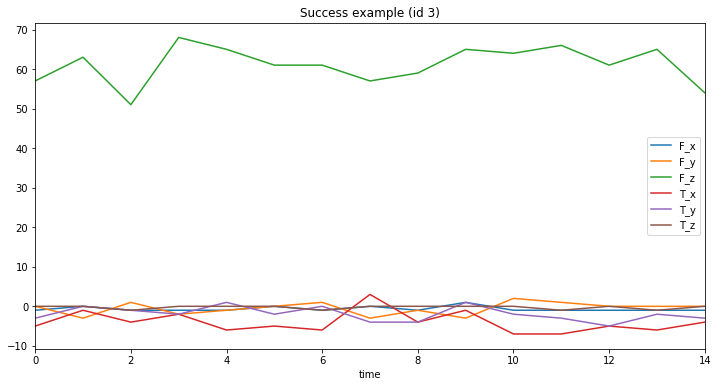

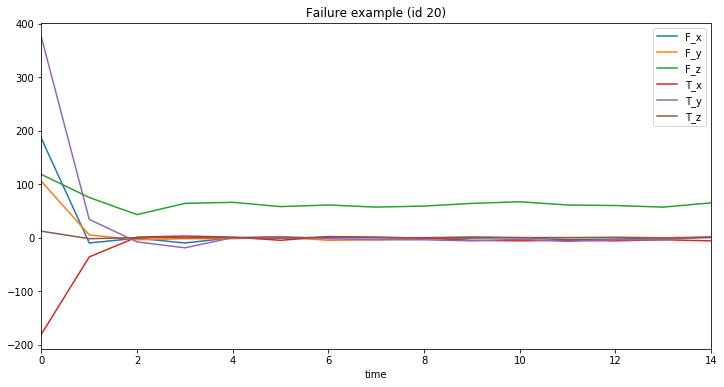

In [4]:
df[df.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

## Extract Features

In [5]:
extraction_settings = ComprehensiveFCParameters()

In [6]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


In [7]:
X.head()

variable,F_x__abs_energy,F_x__absolute_sum_of_changes,"F_x__agg_autocorrelation__f_agg_""mean""__maxlag_40","F_x__agg_autocorrelation__f_agg_""median""__maxlag_40","F_x__agg_autocorrelation__f_agg_""var""__maxlag_40","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","F_x__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,T_z__symmetry_looking__r_0.9,T_z__symmetry_looking__r_0.9500000000000001,T_z__time_reversal_asymmetry_statistic__lag_1,T_z__time_reversal_asymmetry_statistic__lag_2,T_z__time_reversal_asymmetry_statistic__lag_3,T_z__value_count__value_-1,T_z__value_count__value_0,T_z__value_count__value_1,T_z__variance,T_z__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1,14.0,2.0,-0.106351,-7.206633e-02,0.016879,0.0,-1.0,-1.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,15.0,0.0,0.000000,0.0
2,25.0,14.0,-0.039098,-4.935275e-02,0.088790,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.000000,0.000000,0.000000,4.0,11.0,0.0,0.195556,0.0
3,12.0,10.0,-0.029815,1.301043e-17,0.105435,1.0,-1.0,-2.0,0.0,0.0,...,1.0,1.0,0.000000,-0.090909,0.000000,4.0,11.0,0.0,0.195556,0.0
4,16.0,17.0,-0.049773,-6.417112e-02,0.143580,1.0,-1.0,-1.0,0.0,0.0,...,1.0,1.0,0.000000,-0.181818,0.000000,6.0,8.0,1.0,0.355556,0.0
5,17.0,13.0,-0.061467,-5.172414e-02,0.052642,2.0,-1.0,-2.0,0.0,0.0,...,1.0,1.0,-0.076923,-0.090909,-0.222222,4.0,9.0,2.0,0.382222,0.0


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 4536 entries, F_x__abs_energy to T_z__variance_larger_than_standard_deviation
dtypes: float64(4536)
memory usage: 3.0 MB


In [11]:
X_filtered = extract_relevant_features(df, y, 
                                       column_id='id', column_sort='time', 
                                       default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


In [12]:
X_filtered.head()

variable,F_x__value_count__value_-1,F_x__abs_energy,F_x__range_count__max_1__min_-1,F_y__abs_energy,T_y__variance,T_y__standard_deviation,"F_x__fft_coefficient__coeff_1__attr_""abs""","T_y__fft_coefficient__coeff_1__attr_""abs""",T_y__abs_energy,F_z__standard_deviation,...,"T_x__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",T_x__quantile__q_0.1,F_y__has_duplicate_max,"F_y__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2","F_y__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5",T_y__quantile__q_0.1,F_z__time_reversal_asymmetry_statistic__lag_1,F_x__quantile__q_0.2,F_y__quantile__q_0.7
id,,,,,,,,,,,,,,,,,,,,,
1,14.0,14.0,15.0,13.0,0.222222,0.471405,1.000000,1.165352,10.0,1.203698,...,0.0,0.0,-3.0,1.0,-0.310265,-0.751682,-1.0,-596.000000,-1.0,-1.0
2,7.0,25.0,13.0,76.0,4.222222,2.054805,0.624118,6.020261,90.0,4.333846,...,0.0,1.0,-9.2,1.0,-0.202951,0.057818,-3.6,-680.384615,-1.0,-1.0
3,11.0,12.0,14.0,40.0,3.128889,1.768867,2.203858,8.235442,103.0,4.616877,...,0.0,3.0,-6.6,0.0,0.539121,0.912474,-4.0,-617.000000,-1.0,0.0
4,5.0,16.0,10.0,60.0,7.128889,2.669998,0.844394,12.067855,124.0,3.833188,...,0.0,0.0,-9.0,0.0,-2.641390,-0.609735,-4.6,3426.307692,-1.0,1.0
5,9.0,17.0,13.0,46.0,4.160000,2.039608,2.730599,6.445330,180.0,4.841487,...,0.0,0.0,-9.6,0.0,0.591927,0.072771,-5.0,-2609.000000,-1.0,0.8


In [13]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 627 entries, F_x__value_count__value_-1 to F_y__quantile__q_0.7
dtypes: float64(627)
memory usage: 431.8 KB


In [14]:
X_filtered.shape

(88, 627)

In [15]:
X.shape

(88, 4536)

## Train and evaluate classifier

In [16]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)

In [17]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

       False       0.96      0.96      0.96        25
        True       0.91      0.91      0.91        11

    accuracy                           0.94        36
   macro avg       0.93      0.93      0.93        36
weighted avg       0.94      0.94      0.94        36



In [18]:
cl.n_features_

4536

In [19]:
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        25
        True       1.00      0.91      0.95        11

    accuracy                           0.97        36
   macro avg       0.98      0.95      0.97        36
weighted avg       0.97      0.97      0.97        36



In [16]:
cl2.n_features_

513

Compared to using all features (`cl.n_features_`), using only the relevant features (`cl2.n_features_`) achieves better classification performance with less data.

# Extraction + filtering is the same as filtered extraction

Above, we performed two feature extractions runs. A filtered one and a non filtered one. However, the results of the filtered is equal to just extracting all features and then filtering them.

In [20]:
X_filtered_2 = select_features(X, y)

In [21]:
(X_filtered.columns == X_filtered_2.columns).all()

True